# Loading the deeplab model

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from PIL import Image
import numpy as np

In [2]:
def makedirs(dirs):
    if not os.path.exists(dirs):
        os.makedirs(dirs)


def get_device(cuda):
    cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    if cuda:
        print("Device:")
        for i in range(torch.cuda.device_count()):
            print("    {}:".format(i), torch.cuda.get_device_name(i))
    else:
        print("Device: CPU")
    return device


def get_params(model, key):
    # For Dilated FCN
    if key == "1x":
        for m in model.named_modules():
            if "layer" in m[0]:
                if isinstance(m[1], nn.Conv2d):
                    for p in m[1].parameters():
                        yield p
    # For conv weight in the ASPP module
    if key == "10x":
        for m in model.named_modules():
            if "aspp" in m[0]:
                if isinstance(m[1], nn.Conv2d):
                    yield m[1].weight
    # For conv bias in the ASPP module
    if key == "20x":
        for m in model.named_modules():
            if "aspp" in m[0]:
                if isinstance(m[1], nn.Conv2d):
                    yield m[1].bias


def resize_labels(labels, size):
    """
    Downsample labels for 0.5x and 0.75x logits by nearest interpolation.
    Other nearest methods result in misaligned labels.
    -> F.interpolate(labels, shape, mode='nearest')
    -> cv2.resize(labels, shape, interpolation=cv2.INTER_NEAREST)
    """
    new_labels = []
    for label in labels:
        label = label.float().numpy()
        label = Image.fromarray(label).resize(size, resample=Image.NEAREST)
        new_labels.append(np.asarray(label))
    new_labels = torch.LongTensor(new_labels)
    return new_labels

In [3]:
modelpath = 'data/models/coco/deeplabv1_resnet101/caffemodel/deeplabv1_resnet101-coco.pth'

In [4]:
checkpoint = torch.load(modelpath)
checkpoint

OrderedDict([('layer1.conv1.conv.weight',
              tensor([[[[ 1.9581e-02,  2.9540e-02,  8.6358e-03,  ..., -3.5014e-02,
                         -1.3791e-03,  1.0013e-02],
                        [ 2.2902e-03,  6.4532e-04, -5.4466e-02,  ..., -7.5023e-02,
                         -1.7088e-02,  1.5254e-02],
                        [-1.2350e-02, -5.5404e-02, -1.2151e-01,  ..., -2.7517e-02,
                          8.5593e-02,  6.1419e-02],
                        ...,
                        [-1.4657e-02, -1.9516e-02,  5.3405e-02,  ...,  2.4148e-01,
                          1.1085e-03, -9.1235e-02],
                        [ 3.0065e-02,  2.4521e-02,  9.7879e-02,  ..., -4.2010e-02,
                         -1.2280e-01, -6.9298e-02],
                        [ 7.0379e-03,  1.1974e-02,  2.3639e-02,  ..., -9.7277e-02,
                         -6.5781e-02, -3.3026e-02]],
              
                       [[ 4.0113e-02,  2.2531e-02,  4.5038e-03,  ..., -5.9834e-02,
                    

In [5]:
for key, val in checkpoint.items():
    print(key)
    print(val.shape)

layer1.conv1.conv.weight
torch.Size([64, 3, 7, 7])
layer1.conv1.bn.running_mean
torch.Size([64])
layer1.conv1.bn.running_var
torch.Size([64])
layer1.conv1.bn.num_batches_tracked
torch.Size([])
layer1.conv1.bn.weight
torch.Size([64])
layer1.conv1.bn.bias
torch.Size([64])
layer2.block1.shortcut.conv.weight
torch.Size([256, 64, 1, 1])
layer2.block1.shortcut.bn.running_mean
torch.Size([256])
layer2.block1.shortcut.bn.running_var
torch.Size([256])
layer2.block1.shortcut.bn.num_batches_tracked
torch.Size([])
layer2.block1.shortcut.bn.weight
torch.Size([256])
layer2.block1.shortcut.bn.bias
torch.Size([256])
layer2.block1.reduce.conv.weight
torch.Size([64, 64, 1, 1])
layer2.block1.reduce.bn.running_mean
torch.Size([64])
layer2.block1.reduce.bn.running_var
torch.Size([64])
layer2.block1.reduce.bn.num_batches_tracked
torch.Size([])
layer2.block1.reduce.bn.weight
torch.Size([64])
layer2.block1.reduce.bn.bias
torch.Size([64])
layer2.block1.conv3x3.conv.weight
torch.Size([64, 64, 3, 3])
layer2.bloc

In [6]:
checkpoint['layer1.conv1.conv.weight'].shape

torch.Size([64, 3, 7, 7])

In [7]:
from libs.datasets import get_dataset
from addict import Dict
import yaml
import sys

config_path = 'configs/S2DS.yaml'
with open(config_path, 'r') as file:
    CONFIG = Dict(yaml.load(file, Loader=yaml.FullLoader))

for key in CONFIG:
    print(key + ": " + str(CONFIG[key]))
    print("--------")

EXP: {'ID': 'S2DS', 'OUTPUT_DIR': 'data'}
--------
DATASET: {'NAME': 'S2DS', 'ROOT': 'S2DSdevkit/', 'PART': 'merged', 'LABELS': './data/datasets/S2DS/labels.txt', 'N_CLASSES': 6, 'IGNORE_LABEL': 255, 'SCALES': [0.5, 0.75, 1.0, 1.25, 1.5], 'SPLIT': {'TRAIN': 'train', 'VAL': 'val', 'TEST': 'test'}}
--------
DATALOADER: {'NUM_WORKERS': 0}
--------
IMAGE: {'MEAN': {'R': 122.675, 'G': 116.669, 'B': 104.008}, 'SIZE': {'BASE': None, 'TRAIN': 321, 'TEST': 513}}
--------
MODEL: {'NAME': 'DeepLabV2_ResNet101_MSC', 'N_BLOCKS': [3, 4, 23, 3], 'ATROUS_RATES': [6, 12, 18, 24], 'INIT_MODEL': 'data/models/coco/deeplabv1_resnet101/caffemodel/deeplabv1_resnet101-coco.pth'}
--------
SOLVER: {'BATCH_SIZE': {'TRAIN': 5, 'TEST': 1}, 'ITER_MAX': 10000, 'ITER_SIZE': 2, 'ITER_SAVE': 2500, 'ITER_TB': 100, 'LR_DECAY': 10, 'LR': 0.00025, 'MOMENTUM': 0.9, 'OPTIMIZER': 'sgd', 'POLY_POWER': 0.9, 'WEIGHT_DECAY': 0.0005, 'AVERAGE_LOSS': 20}
--------
CRF: {'ITER_MAX': 10, 'POS_W': 3, 'POS_XY_STD': 1, 'BI_W': 4, 'BI_XY_

In [9]:
device = get_device(True)
torch.backends.cudnn.benchmark = True

Device:
    0: Tesla V100-PCIE-16GB
    1: Tesla V100-PCIE-16GB


In [10]:
from libs.datasets import get_dataset
dataset = get_dataset(CONFIG.DATASET.NAME)(
    root=CONFIG.DATASET.ROOT,
    split=CONFIG.DATASET.SPLIT.TRAIN,
    ignore_label=CONFIG.DATASET.IGNORE_LABEL,
    mean_bgr=(CONFIG.IMAGE.MEAN.B, CONFIG.IMAGE.MEAN.G, CONFIG.IMAGE.MEAN.R),
    augment=True,
    base_size=CONFIG.IMAGE.SIZE.BASE,
    crop_size=CONFIG.IMAGE.SIZE.TRAIN,
    scales=CONFIG.DATASET.SCALES,
    flip=True,
)
print(dataset)

Dataset: S2DS
    # data: 200
    Split: train
    Root: S2DSdevkit/part2


In [11]:
# DataLoader
loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=CONFIG.SOLVER.BATCH_SIZE.TRAIN,
    num_workers=CONFIG.DATALOADER.NUM_WORKERS,
    shuffle=True,
)
loader_iter = iter(loader)

In [12]:
# Model check
print("Model:", CONFIG.MODEL.NAME)
assert (
    CONFIG.MODEL.NAME == "DeepLabV2_ResNet101_MSC"
), 'Currently support only "DeepLabV2_ResNet101_MSC"'

Model: DeepLabV2_ResNet101_MSC


In [13]:
image_id, image, label = next(loader_iter)

In [14]:
image_id

('IMG_0752', 'IMG_3006', '01 (316)', '01 (244)', '01 (490)')

In [15]:
image.shape

torch.Size([5, 3, 321, 321])

In [16]:
label.shape

torch.Size([5, 321, 321])

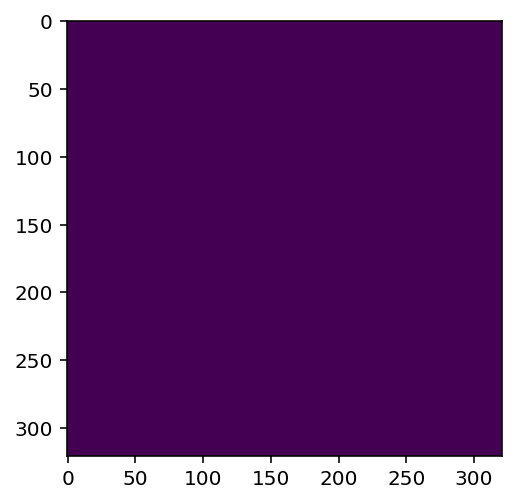

In [17]:
plt.imshow(label[0])

In [26]:
new_labels = resize_labels(label, (21,21))

In [27]:
new_labels.shape

torch.Size([5, 21, 21])

In [29]:
new_labels[1]

tensor([[90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
         90, 90, 90],
        [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
         90, 90, 90],
        [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
         90, 90, 90],
        [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
         90, 90, 90],
        [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
         90, 90, 90],
        [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
         90, 90, 90],
        [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
         90, 90, 90],
        [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
         90, 90, 90],
        [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
         90, 90, 90],
        [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 